In [1]:
import numpy as np # linear algebra
np.random.seed(10)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
        
data = pd.read_csv('train.csv')

data.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


Since this is somewhat of a tutorial, we will use a very basic Multi-Layer Perceptron to predict if a set of passengers survived; as a feature, we will only use the Passenger Class for sake of simplicity.

In [2]:
# We define a dictionary to transform the 0,1 values in the labels to a String that defines the fate of the passenger
dict_live = { 
    0 : 'Perished',
    1 : 'Survived'
}

# We define a dictionary to binarize the sex
dict_sex = {
    'male' : 0,
    'female' : 1
}

# We apply the dictionary using a lambda function and the pandas .apply() module
data['Bsex'] = data['Sex'].apply(lambda x : dict_sex[x])


# Now the features are a 2 column matrix whose entries are the Class (1,2,3) and the Sex (0,1) of the passengers
features = data[['Pclass', 'Bsex']].to_numpy()
labels = data['Survived'].to_numpy()

In [5]:
features

array([[3, 0],
       [1, 1],
       [3, 1],
       ...,
       [3, 1],
       [1, 0],
       [3, 0]])

In [6]:
labels

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [7]:
# Define the sigmoid activator; we ask if we want the sigmoid or its derivative
def sigmoid_act(x, der=False):
    import numpy as np
    
    if (der==True) : #derivative of the sigmoid
        f = x/(1-x)
    else : # sigmoid
        f = 1/(1+ np.exp(-x))
    
    return f

# We may employ the Rectifier Linear Unit (ReLU)
def ReLU_act(x, der=False):
    import numpy as np
    
    if (der== True):
        if x>0 :
            f= 1
        else :
            f = 0
    else :
        if x>0:
            f = x
        else :
            f = 0
    return f

# Now we are ready to define the perceptron; 
# it eats a np.array (that may be a list of features )
def perceptron(X, act='Sigmoid'): 
    import numpy as np
    
    shapes = X.shape # Pick the number of (rows, columns)!
    n= shapes[0]+shapes[1]
    # Generating random weights and bias
    w = 2*np.random.random(shapes) - 0.5 # We want w to be between -1 and 1
    b = np.random.random(1)
    
    # Initialize the function
    f = b[0]
    for i in range(0, X.shape[0]-1) : # run over column elements
        for j in range(0, X.shape[1]-1) : # run over rows elements
            f += w[i, j]*X[i,j]/n
    # Pass it to the activation function and return it as an output
    if act == 'Sigmoid':
        output = sigmoid_act(f)
    else :
        output = ReLU_act(f)
        
    return output

In [8]:
print('Output with sigmoid activator: ', perceptron(features))
print('Output with ReLU activator: ', perceptron(features))

Output with sigmoid activator:  0.8536800619299082
Output with ReLU activator:  0.8515450291672023


In [9]:
import numpy as np

# Define the sigmoid activator; we ask if we want the sigmoid or its derivative
def sigmoid_act(x, der=False):
    import numpy as np
    
    if (der==True) : #derivative of the sigmoid
        f = 1/(1+ np.exp(- x))*(1-1/(1+ np.exp(- x)))
    else : # sigmoid
        f = 1/(1+ np.exp(- x))
    
    return f

# We may employ the Rectifier Linear Unit (ReLU)
def ReLU_act(x, der=False):
    import numpy as np
    
    if (der == True): # the derivative of the ReLU is the Heaviside Theta
        f = np.heaviside(x, 1)
    else :
        f = np.maximum(x, 0)
    
    return f

In [10]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

Training records: 623
Test records: 268


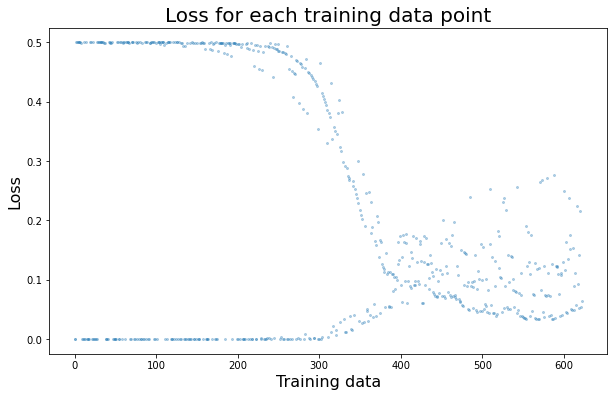

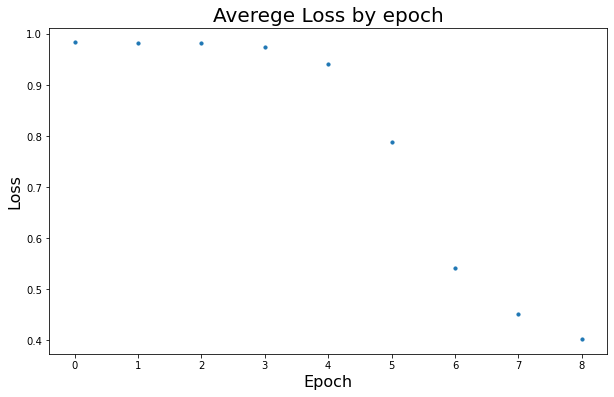

In [11]:
# Set up the number of perceptron per each layer:
p=4 # Layer 1
q=4 # Layer 2

# Set up the Learning rate
eta =  1/623


# 0: Random initialize the relevant data 
w1 = 2*np.random.rand(p , X_train.shape[1]) - 0.5 # Layer 1
b1 = np.random.rand(p)

w2 = 2*np.random.rand(q , p) - 0.5  # Layer 2
b2 = np.random.rand(q)

wOut = 2*np.random.rand(q) - 0.5  # Output Layer
bOut = np.random.rand(1)

mu = []
vec_y = []

# Start looping over the passengers, i.e. over I.

for I in range(0, X_train.shape[0]): #loop in all the passengers:
    
    # 1: input the data 
    x = X_train[I]
    
    
    # 2: Start the algorithm
    
    # 2.1: Feed forward
    z1 = ReLU_act(np.dot(w1, x) + b1) # output layer 1 
    z2 = ReLU_act(np.dot(w2, z1) + b2) # output layer 2
    y = sigmoid_act(np.dot(wOut, z2) + bOut) # Output of the Output layer
    
    #2.2: Compute the output layer's error
    delta_Out =  (y-Y_train[I]) * sigmoid_act(y, der=True)
    
    #2.3: Backpropagate
    delta_2 = delta_Out * wOut * ReLU_act(z2, der=True) # Second Layer Error
    delta_1 = np.dot(delta_2, w2) * ReLU_act(z1, der=True) # First Layer Error
    
    # 3: Gradient descent 
    wOut = wOut - eta*delta_Out*z2  # Outer Layer
    bOut = bOut - eta*delta_Out
    
    w2 = w2 - eta*np.kron(delta_2, z1).reshape(q,p) # Hidden Layer 2
    b2 = b2 - eta*delta_2
    
    w1 = w1 - eta*np.kron(delta_1, x).reshape(p, x.shape[0]) # Hidden Layer 1
    b1 = b1 - eta*delta_1
    
    # 4. Computation of the loss function
    mu.append((1/2)*(y-Y_train[I])**2)
    vec_y.append(y[0])


# Plotting the Cost function for each training data     
plt.figure(figsize=(10,6))
plt.scatter(np.arange(0, X_train.shape[0]), mu, alpha=0.3, s=4, label='mu')
plt.title('Loss for each training data point', fontsize=20)
plt.xlabel('Training data', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

# Plotting the average cost function over 10 training data    
pino = []
for i in range(0, 9):
    pippo = 0
    for m in range(0, 59):
        pippo+=vec_y[60*i+m]/60
    pino.append(pippo)
    
    

plt.figure(figsize=(10,6))
plt.scatter(np.arange(0, 9), pino, alpha=1, s=10, label='error')
plt.title('Averege Loss by epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

In [12]:
def ANN_train(X_train, Y_train, p=4, q=4, eta=0.0015):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # 0: Random initialize the relevant data 
    w1 = 2*np.random.rand(p , X_train.shape[1]) - 0.5 # Layer 1
    b1 = np.random.rand(p)

    w2 = 2*np.random.rand(q , p) - 0.5  # Layer 2
    b2 = np.random.rand(q)

    wOut = 2*np.random.rand(q) - 0.5   # Output Layer
    bOut = np.random.rand(1)

    mu = []
    vec_y = []

    # Start looping over the passengers, i.e. over I.

    for I in range(0, X_train.shape[0]-1): #loop in all the passengers:
    
        # 1: input the data 
        x = X_train[I]
    
        # 2: Start the algorithm
    
        # 2.1: Feed forward
        z1 = ReLU_act(np.dot(w1, x) + b1) # output layer 1 
        z2 = ReLU_act(np.dot(w2, z1) + b2) # output layer 2
        y = sigmoid_act(np.dot(wOut, z2) + bOut) # Output of the Output layer
    
        #2.2: Compute the output layer's error
        delta_Out = 2 * (y-Y_train[I]) * sigmoid_act(y, der=True)
    
        #2.3: Backpropagate
        delta_2 = delta_Out * wOut * ReLU_act(z2, der=True) # Second Layer Error
        delta_1 = np.dot(delta_2, w2) * ReLU_act(z1, der=True) # First Layer Error
    
        # 3: Gradient descent 
        wOut = wOut - eta*delta_Out*z2  # Outer Layer
        bOut = bOut - eta*delta_Out
    
        w2 = w2 - eta*np.kron(delta_2, z1).reshape(q,p) # Hidden Layer 2
        b2 = b2 -  eta*delta_2
    
        w1 = w1 - eta*np.kron(delta_1, x).reshape(p, x.shape[0])
        b1 = b1 - eta*delta_1
    
        # 4. Computation of the loss function
        mu.append((y-Y_train[I])**2)
        vec_y.append(y)
    
    batch_loss = []
    for i in range(0, 10):
        loss_avg = 0
        for m in range(0, 60):
            loss_avg+=vec_y[60*i+m]/60
        batch_loss.append(loss_avg)
    
    
    plt.figure(figsize=(10,6))
    plt.scatter(np.arange(1, len(batch_loss)+1), batch_loss, alpha=1, s=10, label='error')
    plt.title('Averege Loss by epoch', fontsize=20)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.show()
    
    return w1, b1, w2, b2, wOut, bOut, mu

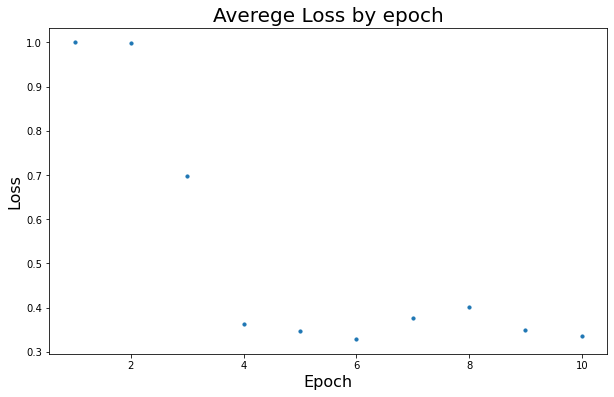

In [13]:
w1, b1, w2, b2, wOut, bOut, mu = ANN_train(X_train, Y_train, p=8, q=4, eta=0.0015)


In [14]:
def ANN_pred(X_test, w1, b1, w2, b2, wOut, bOut, mu):
    import numpy as np
    
    pred = []
    
    for I in range(0, X_test.shape[0]): #loop in all the passengers
        # 1: input the data 
        x = X_test[I]
        
        # 2.1: Feed forward
        z1 = ReLU_act(np.dot(w1, x) + b1) # output layer 1 
        z2 = ReLU_act(np.dot(w2, z1) + b2) # output layer 2
        y = sigmoid_act(np.dot(wOut, z2) + bOut)  # Output of the Output layer
        
        # Append the prediction;
        # We now need a binary classifier; we this apply an Heaviside Theta and we set to 0.5 the threshold
        # if y < 0.5 the output is zero, otherwise is 1
        pred.append( np.heaviside(y - 0.5, 1)[0] )
    
    
    return np.array(pred);


In [15]:
predictions = ANN_pred(X_test, w1, b1, w2, b2, wOut, bOut, mu)


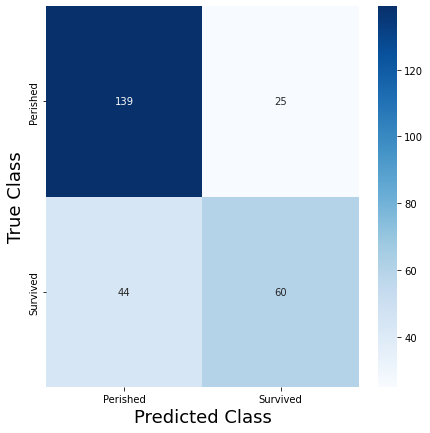

In [16]:
# Plot the confusion matrix
cm = confusion_matrix(Y_test, predictions)

df_cm = pd.DataFrame(cm, index = [dict_live[i] for i in range(0,2)], columns = [dict_live[i] for i in range(0,2)])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Class", fontsize=18)
plt.ylabel("True Class", fontsize=18)
plt.show()

In [18]:
test_data = pd.read_csv('test.csv')

test_data.head(4)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S


In [19]:
# We apply the dictionary using a lambda function and the pandas .apply() module
test_data['Bsex'] = test_data['Sex'].apply(lambda x : dict_sex[x])


X = test_data[['Pclass', 'Bsex']].to_numpy()

test_predictions = ANN_pred(X, w1, b1, w2, b2, wOut, bOut, mu)

In [23]:
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": test_predictions
    })

submission.head(5)

# Export it in a 'Comma Separated Values' (CSV) file
import os
os.chdir('/Users/lucia/Desktop/codigos/MLP/TUTORIAL KAGGLE')
submission.to_csv(r'submission.csv', index=False)
# Creating a link to download the .csv file we created
from IPython.display import FileLink
FileLink(r'submission.csv')

/Users/lucia/Desktop/codigos/MLP/TUTORIAL KAGGLE/submission.csv

In [24]:
'''
Artificial Neural Network Class
'''
class ANN:
    import numpy as np # linear algebra
    np.random.seed(10)
    
    '''
    Initialize the ANN;
    HiddenLayer vector : will contain the Layers' info
    w, b, phi = (empty) arrays that will contain all the w, b and activation functions for all the Layers
    mu = cost function
    eta = a standard learning rate initialization. It can be modified by the 'set_learning_rate' method
    '''
    def __init__(self) :
        self.HiddenLayer = []
        self.w = []
        self.b = []
        self.phi = []
        self.mu = []
        self.eta = 1 #set up the proper Learning Rate!!
    
    '''
    add method: to add layers to the network
    '''
    def add(self, lay = (4, 'ReLU') ):
        self.HiddenLayer.append(lay)
    
    '''
    FeedForward method: as explained before. 
    '''
    @staticmethod
    def FeedForward(w, b, phi, x):
        return phi(np.dot(w, x) + b)
        
    '''
    BackPropagation algorithm implementing the Gradient Descent 
    '''
    def BackPropagation(self, x, z, Y, w, b, phi):
        self.delta = []
        
        # We initialize ausiliar w and b that are used only inside the backpropagation algorithm once called        
        self.W = []
        self.B = []
        
        # We start computing the LAST error, the one for the OutPut Layer 
        self.delta.append(  (z[len(z)-1] - Y) * phi[len(z)-1](z[len(z)-1], der=True) )
        
        '''Now we BACKpropagate'''
        # We thus compute from next-to-last to first
        for i in range(0, len(z)-1):
            self.delta.append( np.dot( self.delta[i], w[len(z)- 1 - i] ) * phi[len(z)- 2 - i](z[len(z)- 2 - i], der=True) )
        
        # We have the error array ordered from last to first; we flip it to order it from first to last
        self.delta = np.flip(self.delta, 0)  
        
        # Now we define the delta as the error divided by the number of training samples
        self.delta = self.delta/self.X.shape[0] 
        
        '''GRADIENT DESCENT'''
        # We start from the first layer that is special, since it is connected to the Input Layer
        self.W.append( w[0] - self.eta * np.kron(self.delta[0], x).reshape( len(z[0]), x.shape[0] ) )
        self.B.append( b[0] - self.eta * self.delta[0] )
        
        # We now descend for all the other Hidden Layers + OutPut Layer
        for i in range(1, len(z)):
            self.W.append( w[i] - self.eta * np.kron(self.delta[i], z[i-1]).reshape(len(z[i]), len(z[i-1])) )
            self.B.append( b[i] - self.eta * self.delta[i] )
        
        # We return the descended parameters w, b
        return np.array(self.W), np.array(self.B)
    
    
    '''
    Fit method: it calls FeedForward and Backpropagation methods
    '''
    def Fit(self, X_train, Y_train):            
        print('Start fitting...')
        '''
        Input layer
        '''
        self.X = X_train
        self.Y = Y_train
        
        '''
        We now initialize the Network by retrieving the Hidden Layers and concatenating them 
        '''
        print('Model recap: \n')
        print('You are fitting an ANN with the following amount of layers: ', len(self.HiddenLayer))
        
        for i in range(0, len(self.HiddenLayer)) :
            print('Layer ', i+1)
            print('Number of neurons: ', self.HiddenLayer[i][0])
            if i==0:
                # We now try to use the He et al. Initialization from ArXiv:1502.01852
                self.w.append( np.random.randn(self.HiddenLayer[i][0] , self.X.shape[1])/np.sqrt(2/self.X.shape[1]) )
                self.b.append( np.random.randn(self.HiddenLayer[i][0])/np.sqrt(2/self.X.shape[1]))
                # Old initialization
                #self.w.append(2 * np.random.rand(self.HiddenLayer[i][0] , self.X.shape[1]) - 0.5)
                #self.b.append(np.random.rand(self.HiddenLayer[i][0]))
                
                # Initialize the Activation function
                for act in Activation_function.list_act():
                    if self.HiddenLayer[i][1] == act :
                        self.phi.append(Activation_function.get_act(act))
                        print('\tActivation: ', act)
                    else :
                # We now try to use the He et al. Initialization from ArXiv:1502.01852
                        self.w.append( np.random.randn(self.HiddenLayer[i][0] , self.HiddenLayer[i-1][0] )/np.sqrt(2/self.HiddenLayer[i-1][0]))
                        self.b.append( np.random.randn(self.HiddenLayer[i][0])/np.sqrt(2/self.HiddenLayer[i-1][0]))
                # Old initialization
                #self.w.append(2*np.random.rand(self.HiddenLayer[i][0] , self.HiddenLayer[i-1][0] ) - 0.5)
                #self.b.append(np.random.rand(self.HiddenLayer[i][0]))
                
                # Initialize the Activation function
                for act in Activation_function.list_act():
                    if self.HiddenLayer[i][1] == act :
                        self.phi.append(Activation_function.get_act(act))
                        print('\tActivation: ', act)
            
        '''
        Now we start the Loop over the training dataset
        '''  
        for I in range(0, self.X.shape[0]): # loop over the training set
            '''
            Now we start the feed forward
            '''  
            self.z = []
            
            self.z.append( self.FeedForward(self.w[0], self.b[0], self.phi[0], self.X[I]) ) # First layers
            
            for i in range(1, len(self.HiddenLayer)): #Looping over layers
                self.z.append( self.FeedForward(self.w[i] , self.b[i], self.phi[i], self.z[i-1] ) )
        
            
            '''
            Here we backpropagate
            '''      
            self.w, self.b  = self.BackPropagation(self.X[I], self.z, self.Y[I], self.w, self.b, self.phi)
            
            '''
            Compute cost function
            ''' 
            self.mu.append(
                (1/2) * np.dot(self.z[len(self.z)-1] - self.Y[I], self.z[len(self.z)-1] - self.Y[I]) 
            )
            
        print('Fit done. \n')
        

    
    '''
    predict method
    '''
    def predict(self, X_test):
        
        print('Starting predictions...')
        
        self.pred = []
        self.XX = X_test
        
        for I in range(0, self.XX.shape[0]): # loop over the training set
            
            '''
            Now we start the feed forward
            '''  
            self.z = []
            
            self.z.append(self.FeedForward(self.w[0] , self.b[0], self.phi[0], self.XX[I])) #First layer
    
            for i in range(1, len(self.HiddenLayer)) : # loop over the layers
                self.z.append( self.FeedForward(self.w[i] , self.b[i], self.phi[i], self.z[i-1]))
       
            # Append the prediction;
            # We now need a binary classifier; we this apply an Heaviside Theta and we set to 0.5 the threshold
            # if y < 0.5 the output is zero, otherwise is zero
            self.pred.append( np.heaviside(  self.z[-1] - 0.5, 1)[0] ) # NB: self.z[-1]  is the last element of the self.z list
        
        print('Predictions done. \n')

        return np.array(self.pred)
   
    '''
    We need a method to retrieve the accuracy for each training data to follow the learning of the ANN
    '''
    def get_accuracy(self):
        return np.array(self.mu)
    # This is the averaged version
    def get_avg_accuracy(self):
        import math
        self.batch_loss = []
        for i in range(0, 10):
            self.loss_avg = 0
            # To set the batch in 10 element/batch we use math.ceil method
            # int(math.ceil((self.X.shape[0]-10) / 10.0))    - 1
            for m in range(0, (int(math.ceil((self.X.shape[0]-10) / 10.0))   )-1):
                #self.loss_avg += self.mu[60*i+m]/60
                self.loss_avg += self.mu[(int(math.ceil((self.X.shape[0]-10) / 10.0)) )*i + m]/(int(math.ceil((self.X.shape[0]-10) / 10.0)) )
            self.batch_loss.append(self.loss_avg)
        return np.array(self.batch_loss)
    '''
    Method to set the learning rate
    '''
    def set_learning_rate(self, et=1):
        self.eta = et
        
        
'''
layers class
'''
class layers :
    '''
    Layer method: used to call standar layers to add. 
    Easily generalizable to more general layers (Pooling and Convolutional layers)
    '''        
    def layer(p=4, activation = 'ReLU'):
        return (p, activation)

'''
Activation functions class
'''
class Activation_function(ANN):
    import numpy as np
    
    def __init__(self) :
        super().__init__()
        
    '''
    Define the sigmoid activator; we ask if we want the sigmoid or its derivative
    '''
    def sigmoid_act(x, der=False):
        if (der==True) : #derivative of the sigmoid
            f = 1/(1+ np.exp(- x))*(1-1/(1+ np.exp(- x)))
        else : # sigmoid
            f = 1/(1+ np.exp(- x))
        return f

    '''
    Define the Rectifier Linear Unit (ReLU)
    '''
    def ReLU_act(x, der=False):
        if (der == True): # the derivative of the ReLU is the Heaviside Theta
            f = np.heaviside(x, 1)
        else :
            f = np.maximum(x, 0)
        return f
    
    def list_act():
        return ['sigmoid', 'ReLU']
    
    def get_act(string = 'ReLU'):
        if string == 'ReLU':
            return ReLU_act
        elif string == 'sigmoid':
            return sigmoid_act
        else :
            return sigmoid_act